In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib widget
import os
import sys
import importlib
import glob
from scipy.signal import find_peaks


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import tools
import bode_tools
import DREAM_colors as dc
import math_functions as mf
import BodeClass_PSI as bc
import ExperimentClass as ec

importlib.reload(tools)
importlib.reload(mf)
importlib.reload(bc)
importlib.reload(ec)
importlib.reload(dc)


<module 'DREAM_colors' from 'c:\\Users\\Orlando\\Desktop\\DREAM_repo\\DREAM_colors.py'>

In [2]:
record_list = ["P0.0625s", "P0.0625s_AL"]

name = "20240927_phase_test"

light_osci = "3$E_k$ ± 0.5$E_k$"

exp = ec.Experiment(name, "PSI", DataType = ".csv", sep = ';')

fig_folder = exp.path + "/figures/"
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)



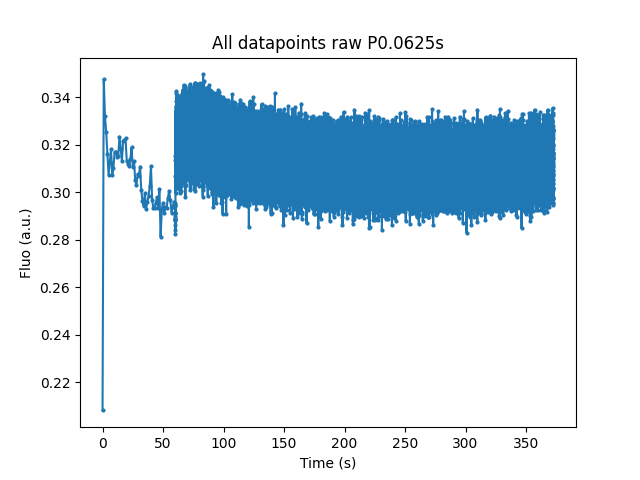

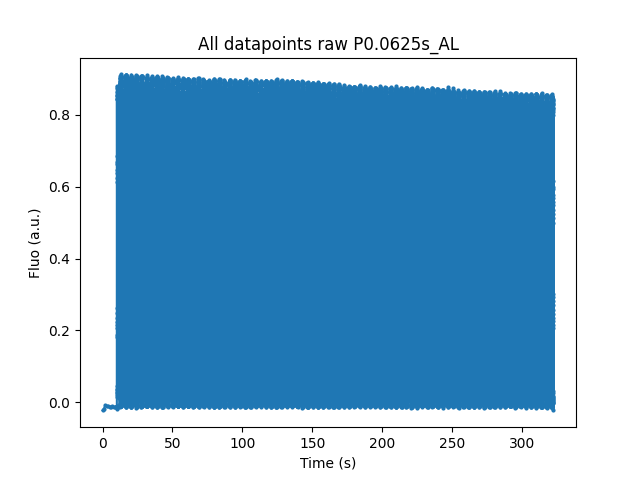

In [3]:
for record in record_list:
    fig, ax = plt.subplots()
    index = exp.records.index(record)
    ax.plot(exp.clean_times[index], exp.clean_data[index], '-o', markersize=2)
    ax.set_title(f"All datapoints raw {record}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Fluo (a.u.)")

In [4]:
t_start = 0.25
t_end = 312.67188


pre_illumination_time = 60
pre_illumination_time_AL = 10

In [5]:
index = exp.records.index("P0.0625s")
ind_start = tools.closest_index(exp.clean_times[index], t_start + pre_illumination_time)
ind_end = tools.closest_index(exp.clean_times[index], t_end + pre_illumination_time)
time = exp.clean_times[index][ind_start:ind_end] - (t_start + pre_illumination_time)
data = exp.clean_data[index][ind_start:ind_end]

index = exp.records.index("P0.0625s_AL")
ind_start_AL = tools.closest_index(exp.clean_times[index], t_start + pre_illumination_time_AL)
ind_end_AL = tools.closest_index(exp.clean_times[index], t_end + pre_illumination_time_AL)
time_AL = exp.clean_times[index][ind_start_AL:ind_end_AL] - (t_start + pre_illumination_time_AL)
data_AL = exp.clean_data[index][ind_start_AL:ind_end_AL]



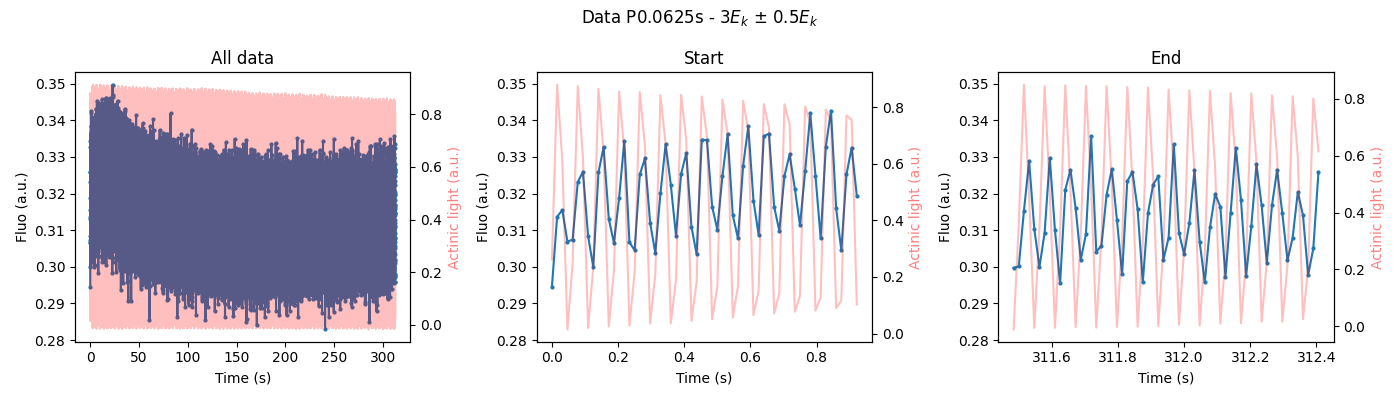

In [6]:
fig, ax = plt.subplots(1, 3 , figsize = (14, 4))
fig.suptitle(f"Data P0.0625s - {light_osci}")
per_to_show = 6
ax[0].plot(time, data, '-o', markersize=2, label = "Fluo")
ax[0].set_title("All data")
ax[1].plot(time[:per_to_show*10], data[:per_to_show*10], '-o', markersize=2, label = "Fluo")
ax[1].set_ylim(ax[0].get_ylim())
ax[1].set_title("Start")
ax[2].plot(time[-per_to_show*10:], data[-per_to_show*10:], '-o', markersize=2, label = "Fluo")
ax[2].set_ylim(ax[0].get_ylim())
ax[2].set_title("End")

for j, ax in enumerate(ax):
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Fluo (a.u.)")
    ax2 = ax.twinx()
    if j == 0:
        ax2.plot(time_AL, data_AL, '-', markersize=2, color = 'red', alpha = 0.25)
    elif j == 1:
        ax2.plot(time_AL[:per_to_show*10], data_AL[:per_to_show*10], '-', markersize=2, color = 'red', alpha = 0.25)
    else:
        ax2.plot(time_AL[-per_to_show*10:], data_AL[-per_to_show*10:], '-', markersize=2, color = 'red', alpha = 0.25)

    ax2.set_ylabel("Actinic light (a.u.)", color = 'red', alpha = 0.5)
    #ax2.tick_params(axis='y', colors='red')
    #ax2.spines['right'].set_color('red')
    
fig.tight_layout()
fig.savefig(fig_folder + f"Raw_data_P0.0625s.png")
#ax.set_ylim(0, 1.1)

In [7]:
dspline = 800
order = 4

detrended_data, fit = bode_tools.spline_detrending(data, order = order, dspline = dspline)


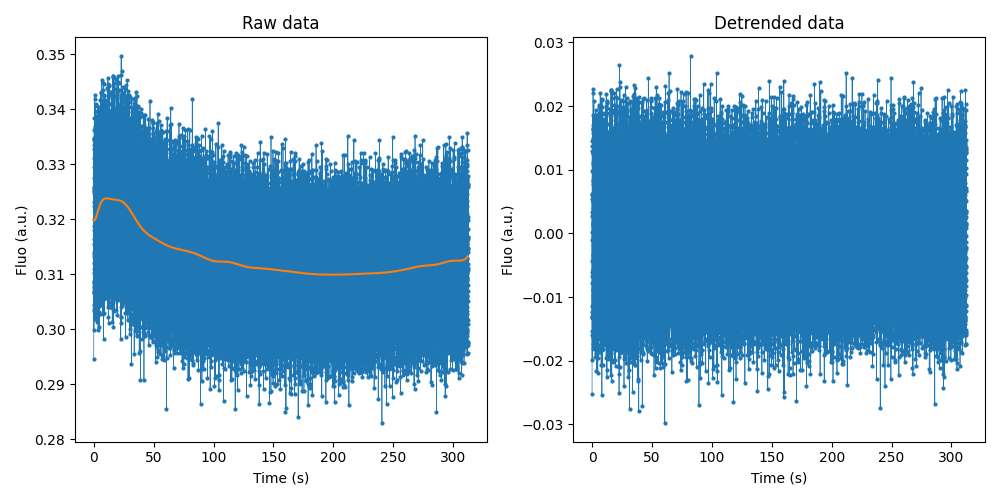

In [8]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(time, data, '-o', markersize=2, linewidth = 0.5)
ax[0].plot(time, fit)
ax[0].set_title(f"Raw data")
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Fluo (a.u.)")
ax[1].plot(time, detrended_data, '-o', markersize=2, linewidth = 0.5)
ax[1].set_title("Detrended data")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Fluo (a.u.)")
fig.tight_layout()

In [9]:
def get_harmonics(input_freq, F, A, P, pic_search_window):
    index_fund = tools.closest_index(F, input_freq)
    search_window = [index_fund - pic_search_window, index_fund + pic_search_window]
    index_max = np.argmax(A[search_window[0]:search_window[1]]) + search_window[0]
    harmonics = {'f_input': input_freq}
    for i in range(2):
        harmonics[f'A_{i}'] = A[index_max * (i+1)]
        harmonics[f'f_{i}'] = F[index_max * (i+1)]
        harmonics[f'P_{i}'] = P[index_max * (i+1)]

    return pd.DataFrame(harmonics, index=[0])

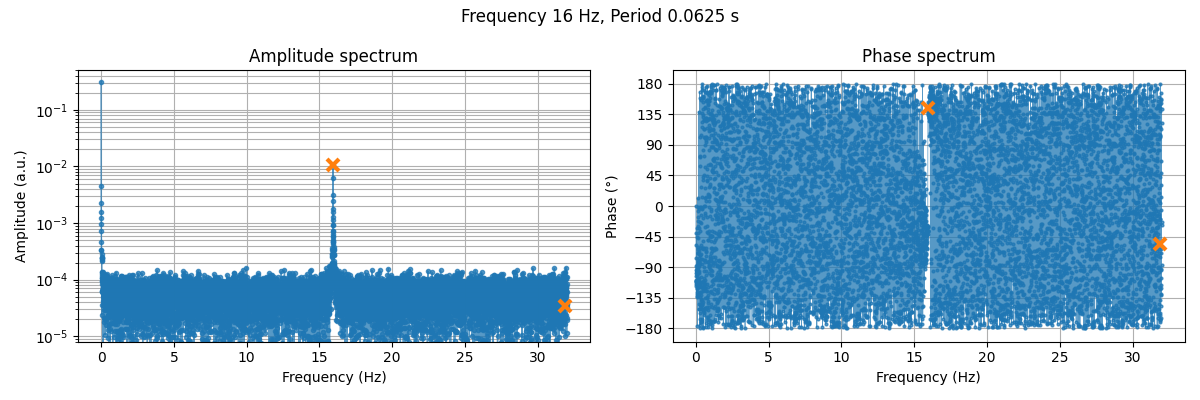

In [10]:
F, A, P = tools.FFT(time, data)
harmonics = get_harmonics(16, F, A, P, int(len(F)/20))

fig, ax = plt.subplots(1,2, figsize=(12,4))
fig.suptitle(f"Frequency 16 Hz, Period 0.0625 s")
ax[0].semilogy(F, A, '-o', markersize=3, linewidth=1, alpha=0.75)
ax[0].set_title(f"Amplitude spectrum")
ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_ylabel("Amplitude (a.u.)")
ax[0].grid(which = 'both')
ax[0].set_ylim(8e-6, 5e-1)
ax[1].plot(F, P, '-o', markersize=2, linewidth=0.5, alpha=0.75)
ax[1].set_title(f"Phase spectrum")
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("Phase (°)")
ax[1].grid(which = 'both')
for j in range(2):
    ax[0].plot(np.array(harmonics[f'f_{j}']), np.array(harmonics[f'A_{j}']), "x", markersize=8, markeredgewidth=3, color = 'C1')
    ax[1].plot(np.array(harmonics[f'f_{j}']), np.array(harmonics[f'P_{j}']), "x", markersize=8, markeredgewidth=3, color = 'C1')

ax[1].set_ylim(-200, 200)
ax[1].set_yticks(np.arange(-180, 180 + 45, 45)) 
    

fig.tight_layout()
fig.savefig(fig_folder + f"FFT.png", dpi = 300)


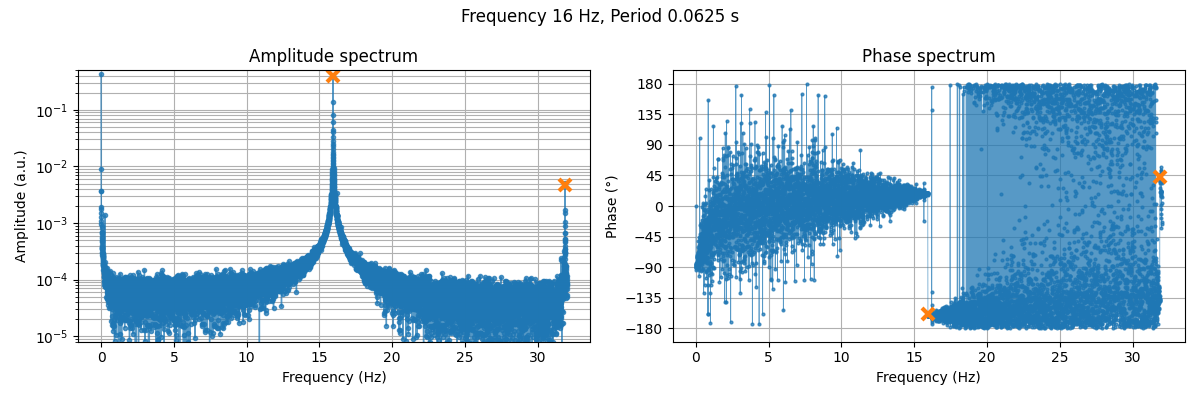

In [85]:
F_AL, A_AL, P_AL = tools.FFT(time_AL, data_AL)
harmonics_AL = get_harmonics(16, F_AL, A_AL, P_AL, int(len(F_AL)/20))

fig, ax = plt.subplots(1,2, figsize=(12,4))
fig.suptitle(f"Frequency 16 Hz, Period 0.0625 s")
ax[0].semilogy(F_AL, A_AL, '-o', markersize=3, linewidth=1, alpha=0.75)
ax[0].set_title(f"Amplitude spectrum")
ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_ylabel("Amplitude (a.u.)")
ax[0].grid(which = 'both')
ax[0].set_ylim(8e-6, 5e-1)
ax[1].plot(F_AL, P_AL, '-o', markersize=2, linewidth=0.5, alpha=0.75)
ax[1].set_title(f"Phase spectrum")
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("Phase (°)")
ax[1].grid(which = 'both')
for j in range(2):
    ax[0].plot(np.array(harmonics_AL[f'f_{j}']), np.array(harmonics_AL[f'A_{j}']), "x", markersize=8, markeredgewidth=3, color = 'C1')
    ax[1].plot(np.array(harmonics_AL[f'f_{j}']), np.array(harmonics_AL[f'P_{j}']), "x", markersize=8, markeredgewidth=3, color = 'C1')

ax[1].set_ylim(-200, 200)
ax[1].set_yticks(np.arange(-180, 180 + 45, 45)) 
    

fig.tight_layout()
fig.savefig(fig_folder + f"FFT_AL.png", dpi = 300)


In [73]:
def sinusoid(t, A, f, P, D):
    return A * np.cos(2 * np.pi * f * t + np.deg2rad(P)) + D

In [135]:
from scipy.optimize import differential_evolution

# Define the sinusoidal function
def sinusoid(x, A, B, C, D):
    return A * np.cos(2 * np.pi * (B * x + C)) + D

# Define the objective function to minimize
def objective(params, x, y):
    A, B, C, D = params
    return np.sum((sinusoid(x, A, B, C, D) - y) ** 2)

def get_harmonics_by_fitting(input_freq, time, data):
    harmonics = {'f_input': input_freq}

    # Bounds for the parameters: [A, B, C, D]
    bounds = [(0.2, 0.6), (input_freq - 0.01 * input_freq, input_freq + 0.01 * input_freq), (-np.pi, np.pi), (0.4, 0.5)]
    
    # Differential evolution optimization
    result = differential_evolution(objective, bounds, args=(time, data))
    A_fit, B_fit, C_fit, D_fit = result.x

    harmonics['A_0'] = A_fit
    harmonics['f_0'] = B_fit
    harmonics['P_0'] = np.rad2deg(C_fit)
    harmonics['D_0'] = D_fit

    return pd.DataFrame(harmonics, index=[0]), result



In [136]:
harmonics_fit, results = get_harmonics_by_fitting(16, time, data)
harmonics_fit


,f_input,A_0,f_0,P_0,D_0
0,16,0.2,15.932374,-80.995096,0.4


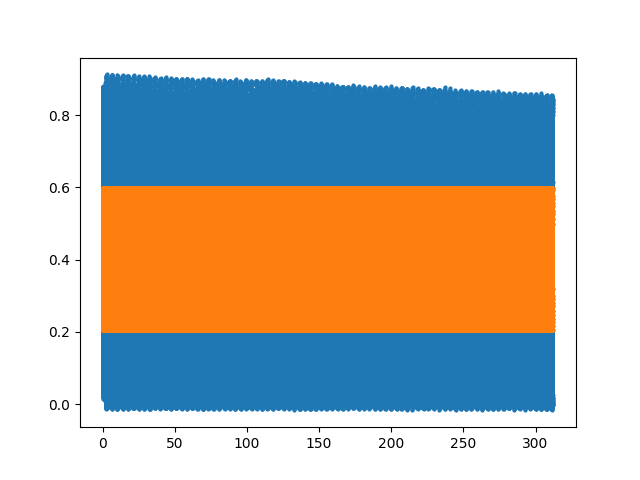

In [137]:
fig, ax = plt.subplots()

time_fit = np.arange(0, time_AL[-1], 0.0001)
ax.plot(time_AL, data_AL, '-o', markersize=2)
ax.plot(time_fit, sinusoid(time_fit,*results.x), label = "Fit")

In [127]:
harmonics_AL

,f_input,A_0,f_0,P_0,A_1,f_1,P_1
0,16,0.402379,15.933583,-159.786252,0.004667,31.867167,42.304224


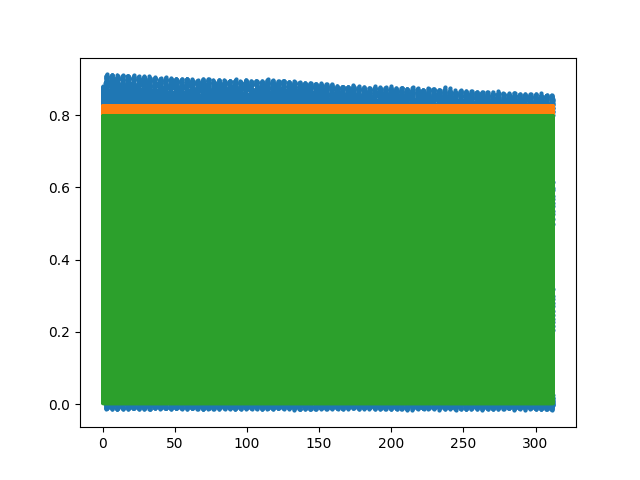

In [125]:
fig, ax = plt.subplots()

time_fit = np.arange(0, time_AL[-1], 0.0001)
ax.plot(time_AL, data_AL, '-o', markersize=2)
#ax.plot(time_fit, sinusoid(time_fit, harmonics_AL["A_0"].values[0], harmonics_AL["f_0"].values[0], harmonics_AL["P_0"].values[0], A_AL[0]), label = "Fit")
ax.plot(time_fit, sinusoid(time_fit, harmonics_AL["A_0"].values[0], 15.93, harmonics_AL["P_0"].values[0], A_AL[0]), label = "Fit")
ax.plot(time_fit, sinusoid(time_fit,*results.x), label = "Fit")



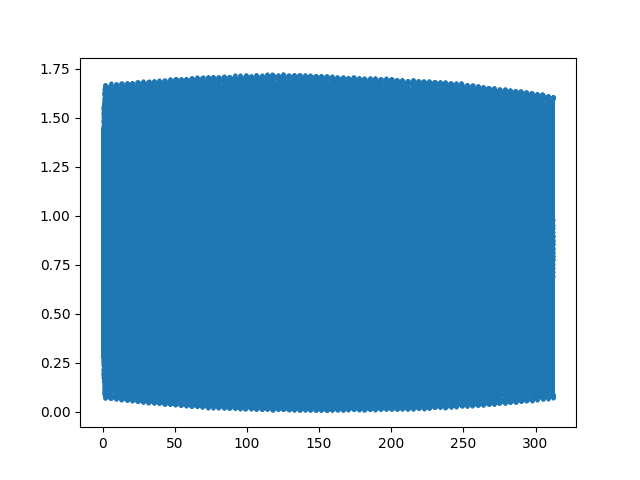

In [88]:
fig, ax = plt.subplots()

time_fit = np.arange(0, time_AL[-1], 0.0001)
ax.plot(time_AL, data_AL + sinusoid(time_AL, harmonics_AL["A_0"].values[0], harmonics_AL["f_0"].values[0], harmonics_AL["P_0"].values[0], A_AL[0]), '-o', markersize=2)

In [13]:
ref_phase = harmonics_AL['P_0'].values[0]
phase = harmonics['P_0'].values[0]

print(f"Reference phase: {ref_phase}")
print(f"Phase: {phase}")


Reference phase: -159.78625193953087
Phase: 144.36065920311088


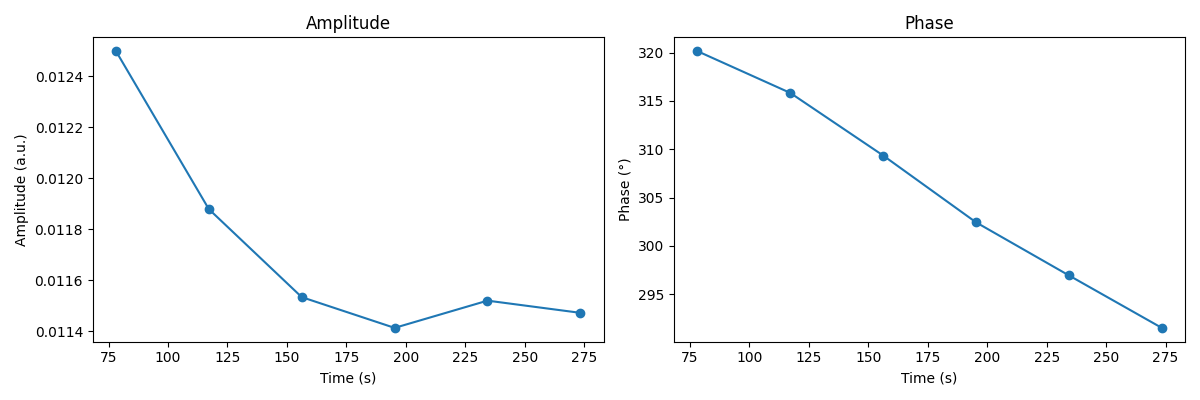

In [54]:
nb_of_periods = int(time[-1] * 16)
periods_per_window = int(np.ceil(nb_of_periods / 10))
overlap_periods = int(np.floor(periods_per_window / 2))

A_fund = []
P_fund = []
time_spectrogram = []

step = 10 * (periods_per_window - overlap_periods)  # Step size based on overlap
data_length = len(detrended_data)

# Main loop to process chunks
for i in range(0, data_length - periods_per_window * 10 + 1, step):
    time_spectrogram.append(time[i + periods_per_window * 10 -1])
    F, A, P = tools.FFT(time[i:i + periods_per_window * 10], 
                        detrended_data[i:i + periods_per_window * 10])
    F_ref, A_ref, P_ref = tools.FFT(time[i:i + periods_per_window * 10], data_AL[i:i + periods_per_window * 10] - np.mean(data_AL[i:i + periods_per_window * 10]))
    
    A_fund.append(A[np.argmax(A)])
    P_fund.append(P[np.argmax(A)] - P_ref[np.argmax(A_ref)])

P_fund = np.rad2deg(np.unwrap(np.deg2rad(P_fund)))

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(time_spectrogram, A_fund, '-o')
ax[0].set_title("Amplitude")
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Amplitude (a.u.)")
#ax[0].set_ylim(0, 0.02)

ax[1].plot(time_spectrogram, P_fund, '-o')
ax[1].set_title("Phase")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Phase (°)")

fig.tight_layout()
